# Importing packages and Intro

Plan:
1. Import packages and data
2. Perform basic data processing and analysis (to do - visualize outliers, and then potentially use VAE to remove noise?)
3. Run shallow learning methods to provide baseline - use nested K Fold cross validation for HP tuning and evaluation for maximum reliability
4. Perform basic EDA on which type of feed forward neural network could be best - start by trying to overfit, to prove we have enough generalizing power (no need to do full holdout/K Fold validation for HP tuning as this is basic EDA for now)
5. Automate HP tuning. Use the lessons learned from EDA and manual HP tuning to pick a sensible search space.
6. Test automated HP tuning on holdout test set (or ideally nested K Fold if we have the compute)

In [ ]:
#import packages:

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  # This is a more robust approach than relying on potentially internal variables.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  else:
    print("Google Drive is already mounted.")
else:
  print("Not running in Google Colab. Drive mounting skipped.")

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#tf and table one
import tensorflow as tf
!pip install tableone
from tableone import TableOne
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping


#sklearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import RandomOverSampler

!pip install keras_tuner
import keras_tuner as kt




Google Drive is already mounted.


In [ ]:

#if using colabs - will need to first mount your drive

#change these for different users

# File paths (update if needed)
data_set_filepath = '/content/drive/MyDrive/Colab_Notebooks/Data/diabetes.csv'

print("Data loaded")



Data loaded




---

# Data Analysis

In [ ]:
# Preprocessing function (modified for pandas)
def load_data(data_set_filepath = '/content/drive/MyDrive/Colab_Notebooks/Data/diabetes.csv'):

  df = pd.read_csv(data_set_filepath)

  return df

df = load_data()

columns = df.columns.tolist()

print(f"The dataset lenghth is {str(len(df))}")
print(f"The number of columns is {str(len(columns))}")
print(f"The column names are {str(columns)}")
df.head(10)

table1 = TableOne(df, columns=columns, groupby= 'Outcome', pval=True)
print(table1)


The dataset lenghth is 768
The number of columns is 9
The column names are ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
                                     Grouped by Outcome                                                   
                                                Missing       Overall             0              1 P-Value
n                                                                 768           500            268        
Pregnancies, mean (SD)                                0     3.8 (3.4)     3.3 (3.0)      4.9 (3.7)  <0.001
Glucose, mean (SD)                                    0  120.9 (32.0)  110.0 (26.1)   141.3 (31.9)  <0.001
BloodPressure, mean (SD)                              0   69.1 (19.4)   68.2 (18.1)    70.8 (21.5)   0.087
SkinThickness, mean (SD)                              0   20.5 (16.0)   19.7 (14.9)    22.2 (17.7)   0.049
Insulin, mean (SD)                                 



---

# Shallow (Interpretable) Learning models


So not much data preprocessing needed, as we can see from the Table1. We will incorporate Batch Normalization to scale features anyway.

Let's see how well our basic shallow models do, using a function I wrote in other scripts.

In [ ]:


def run_models(model_type, X, y):
    """
    Runs Logistic Regression (LR), Decision Tree (DT), or Random Forest (RF) model using nested cross-validation with oversampling.
    """
    # Scale data only for Logistic Regression
    if model_type.upper() == 'LR':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = X.values  # Convert to NumPy array for consistency

    # Define outer and inner cross-validation
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Initialize the model and hyperparameter grid
    if model_type.upper() == 'LR':
        model = LogisticRegression(max_iter=1000)
        param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
        print("Running nested cross-validation for Logistic Regression ")

    elif model_type.upper() == 'DT':
        model = DecisionTreeClassifier()
        param_grid = {
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10],
            'criterion': ['gini', 'entropy']
        }
        print("Running nested cross-validation for Decision Tree ")

    elif model_type.upper() == 'RF':
        model = RandomForestClassifier()
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10],
        }
        print("Running nested cross-validation for Random Forest.")

    elif model_type.upper() == 'GBM':
        model = GradientBoostingClassifier()  # Initialize GBM model
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        }

        print("Running nested cross-validation for Gradient Boosting Machine with oversampling.")

    else:
        print("Invalid model type. Please choose 'LR', 'DT', 'RF' or 'GBM'.")
        return

    # Store outer fold scores
    outer_scores = []

    # Loop through outer folds
    for train_index, val_index in tqdm(outer_cv.split(X, y)):
        # Split data into training and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]


        # Inner cross-validation with oversampling
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1
        )

        # Fit the model on the resampled training data
        grid_search.fit(X_train_fold, y_train_fold)

        # Evaluate the best model on the validation data
        best_model = grid_search.best_estimator_
        y_val_pred_proba = best_model.predict_proba(X_val_fold)[:, 1]
        best_score = roc_auc_score(y_val_fold, y_val_pred_proba)

        # Store the best score
        outer_scores.append(best_score)

    # Print the average ROC AUC score
    print(f"Average Validation ROC AUC from nested cross-validation ({model_type.upper()}): {np.mean(outer_scores):.4f}")

X = df.drop('Outcome', axis=1)
y = df['Outcome']

run_models('LR', X, y)
run_models('DT', X, y)
run_models('RF', X, y)
run_models('GBM', X, y)




Running nested cross-validation for Logistic Regression 


3it [00:07,  2.42s/it]


Average Validation ROC AUC from nested cross-validation (LR): 0.8314
Running nested cross-validation for Decision Tree 


3it [00:04,  1.40s/it]


Average Validation ROC AUC from nested cross-validation (DT): 0.7563
Running nested cross-validation for Random Forest with oversampling.


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
3it [02:42, 54.28s/it]


Average Validation ROC AUC from nested cross-validation (RF): 0.8248
Running nested cross-validation for Gradient Boosting Machine with oversampling.


3it [34:51, 697.33s/it]

Average Validation ROC AUC from nested cross-validation (GBM): 0.8257




---

# Basic Deep Learning EDA

So with our basic shallow learning techniques we didn't do so well - we got around a 80% average AUC across the folds at best, out of Logistic Regression, DT and RF. This suggests are data could be highly non linear in nature. Let's try some deep learning. Below will be our first try, with an out of the box keras feed forward neural net.


 **FIRST TRY AT FFNN (Feed Forward Neural Network)**


Training fold 1...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1 ROC AUC Score: 0.7020


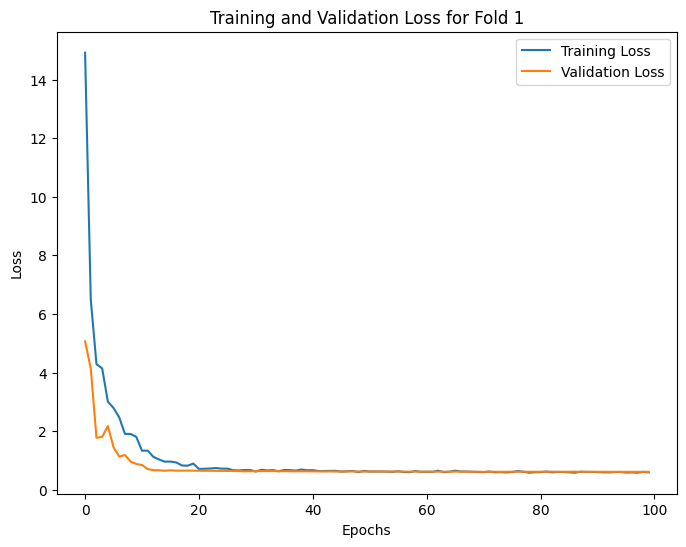


Training fold 2...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 ROC AUC Score: 0.7190


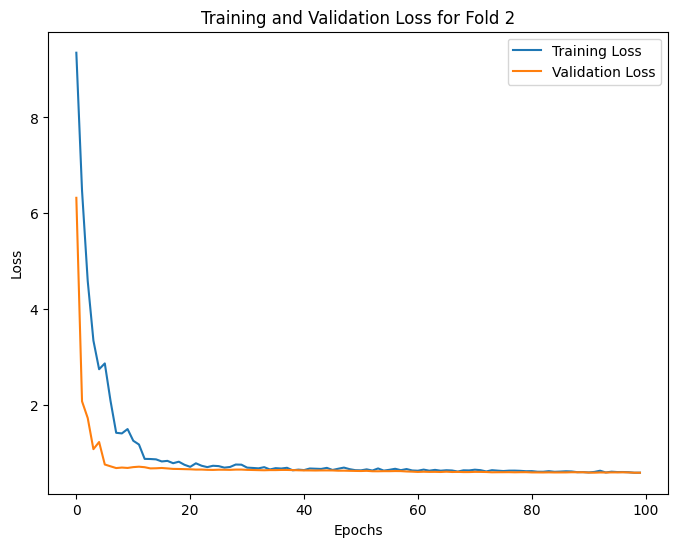


Training fold 3...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 ROC AUC Score: 0.7368


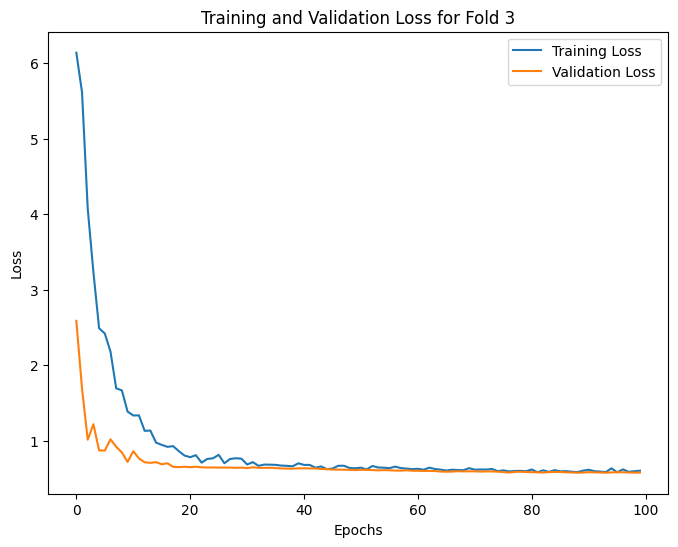

In [ ]:
#data
X = df.drop('Outcome', axis=1)
#labels
y = df['Outcome']



def create_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Stratified K-Fold Cross Validation
k_folds = 3
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_no = 1

for train_index, val_index in skf.split(X, y):
    print(f"\nTraining fold {fold_no}...\n")

    # Split data for current fold using .iloc for safe selection by position
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create model
    model = create_model(X_train.shape[1])

    # Implement EarlyStopping to monitor validation loss
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,    # Stop after 100 epochs with no improvement. given max epochs is 100 this won't even do anything but we will amend later
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,  # Adjust as needed
        batch_size=32,  # Adjust based on GPU memory
        verbose=0,
        callbacks=[early_stopping]  # Add early stopping callback
    )

    # Compute and print ROC AUC Score for this fold
    y_val_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    print(f"Fold {fold_no} ROC AUC Score: {roc_auc:.4f}")

    # Plot training and validation loss for this fold
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    # Move to next fold
    fold_no += 1

Our initial results are not great. We are only getting a ROC AUC of around 60% - poor compared to even a simple Logistic Regression.

It doesn't seem to have a lot of capacity to generalize very well - it seems we haven't actually been able to overfit, no matter how hard we try.

But first we will try adding batch normalization - since we have only done minimal preprocessing this might help narrow down the issue, and it can also slightly help with overfitting.

We will also not use K Fold Cross Validation - we likely don't have enough data, so we will use Iterated K-Fold with shuffling.



Training fold 1...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1 ROC AUC Score: 0.8144


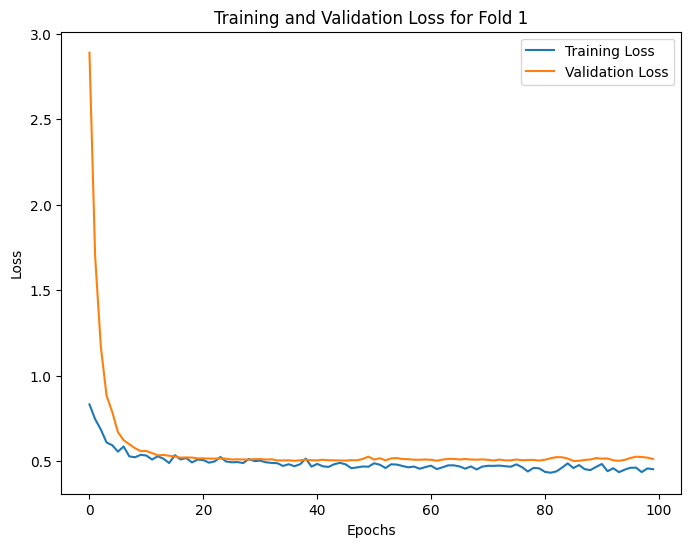


Training fold 2...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 2 ROC AUC Score: 0.8589


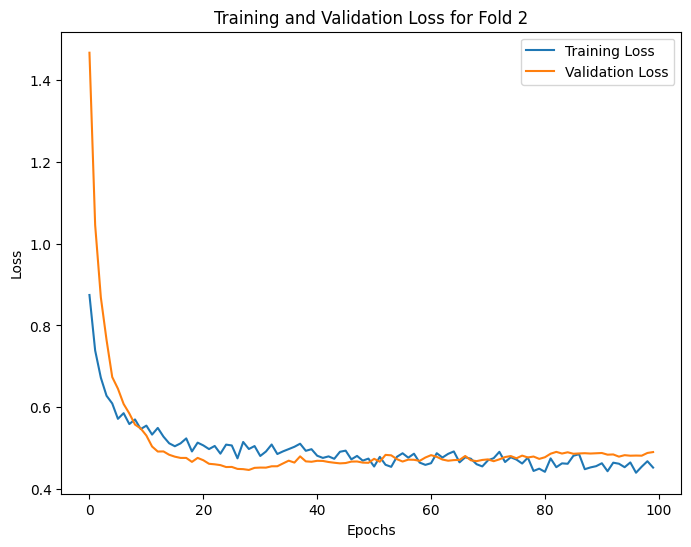


Training fold 3...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 ROC AUC Score: 0.8106


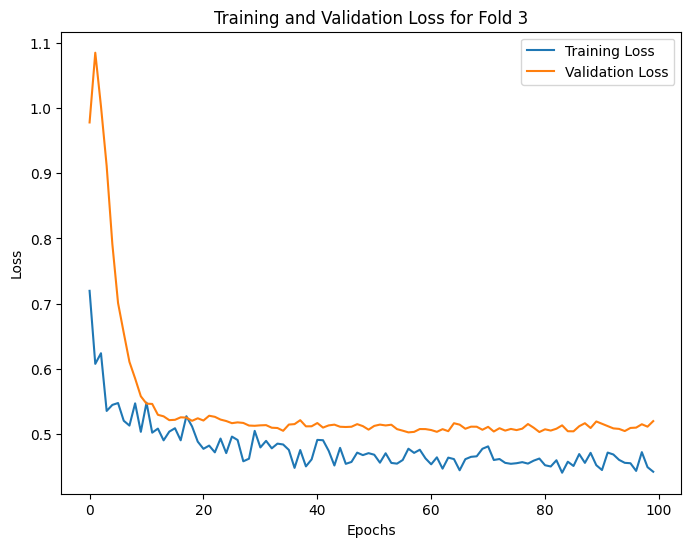


Training fold 4...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 ROC AUC Score: 0.8059


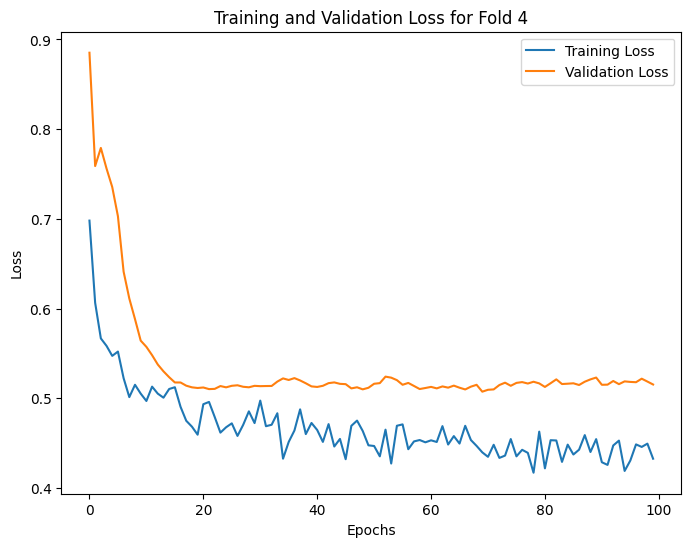


Training fold 5...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5 ROC AUC Score: 0.8612


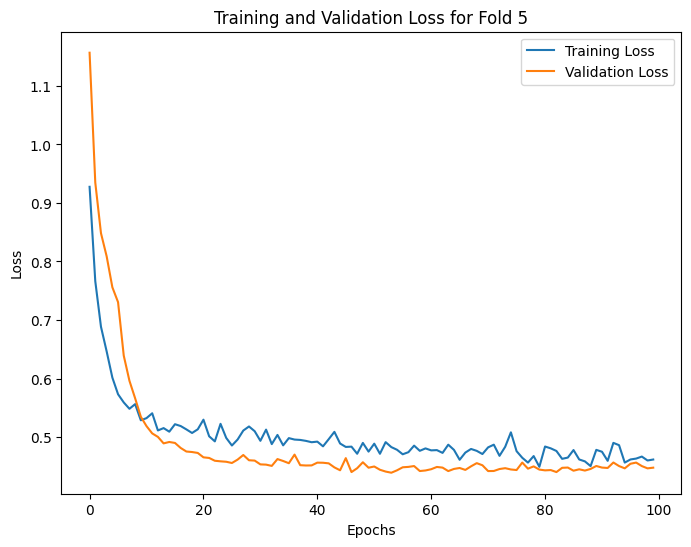


Training fold 6...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Fold 6 ROC AUC Score: 0.8372


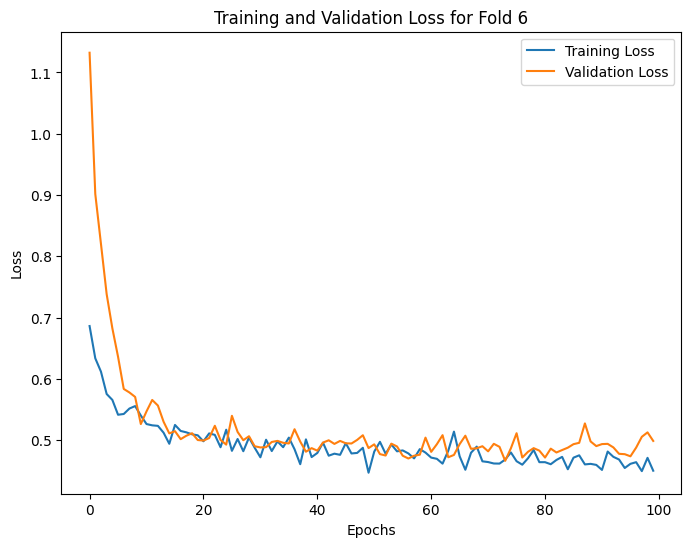


Training fold 7...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 7 ROC AUC Score: 0.8478


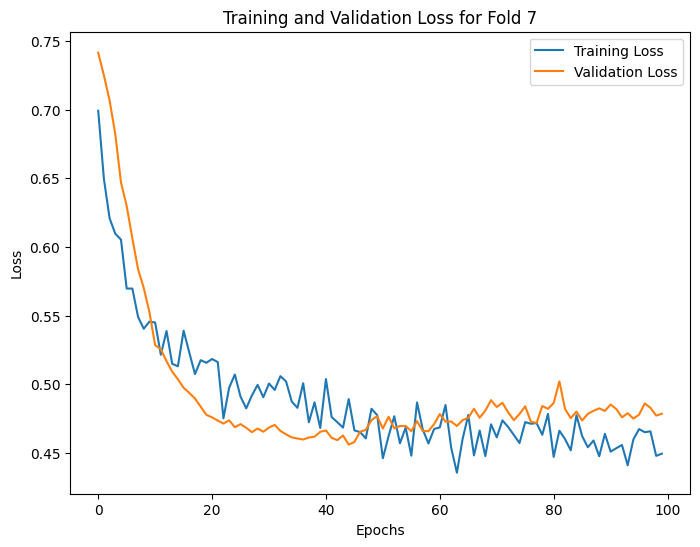


Training fold 8...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 8 ROC AUC Score: 0.8144


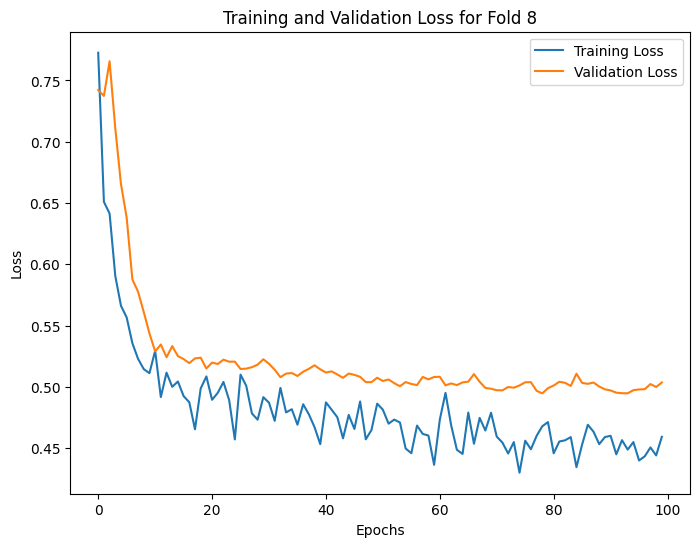


Training fold 9...

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 9 ROC AUC Score: 0.8393


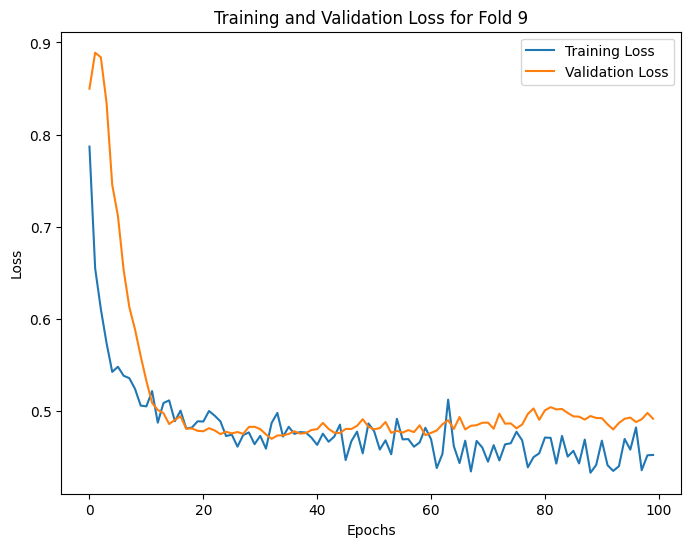


Average ROC AUC Score across all folds: 0.8322


In [ ]:
#data
X = df.drop('Outcome', axis=1)
#labels
y = df['Outcome']

# Define model architecture with specific layer settings
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))       # Input layer
    x = Dense(32, use_bias=False)(inputs)      # First dense layer without bias
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    x = Dropout(0.1)(x)                        # Dropout layer to prevent overfitting

    x = Dense(16, use_bias=False)(x)           # Second dense layer without bias
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    x = Dropout(0.1)(x)                        # Dropout layer

    outputs = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid for binary classification
    model = Model(inputs=inputs, outputs=outputs)  # Define the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])           # Compile with Adam optimizer and binary cross-entropy loss
    return model

# Define iterated k-fold cross-validation with shuffling
k_folds = 3                # Number of folds
n_repeats = 3              # Number of repetitions
rkf = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=42)
fold_no = 1

# Store AUC scores for all folds
auc_scores = []

for train_index, val_index in rkf.split(X, y):
    print(f"\nTraining fold {fold_no}...\n")

    # Split data for current fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create model
    model = create_model(X_train.shape[1])

    # EarlyStopping callback to avoid overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,                   # Stop after 10 epochs with no improvement
        restore_best_weights=True      # Restore best weights after stopping
    )

    # Train model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,                    # Maximum number of epochs
        batch_size=16,                 # Smaller batch size for better generalization
        verbose=0,
        callbacks=[early_stopping]     # Add early stopping callback
    )

    # Compute and store ROC AUC Score for the holdout set
    y_val_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(roc_auc)
    print(f"Fold {fold_no} ROC AUC Score: {roc_auc:.4f}")

    # Plot training and validation loss for each fold
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    fold_no += 1

# Print overall average AUC score across all folds
average_auc = np.mean(auc_scores)
print(f"\nAverage ROC AUC Score across all folds: {average_auc:.4f}")

Now we have an average AUC of around 83% - this is much better, just by implementing batch normalization. We are now competing with our Random Forest method.

But there's one key issue - when training, we WANT to first overfit, to ensure we have enough generalization power, then work on regularization, or model trimming, or other ways to reduce overfitting.

If we had overfit we would see validation loss start to increase (given that our patience value is so high).

So we need to try increase our generalization power. Let's really try get this to overfit, so we know it's actually capable of doing so, and we can work backwards from there.


# Trying to Overfit (HP EDA)


Training fold 1...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 1 ROC AUC Score: 0.8326


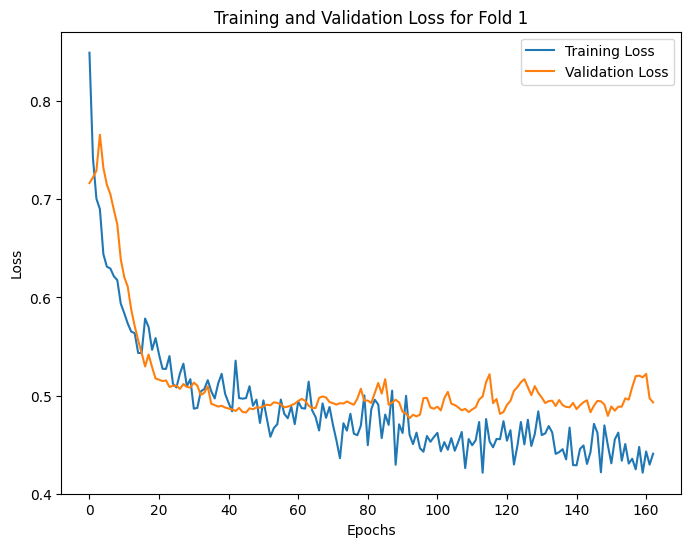


Training fold 2...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 2 ROC AUC Score: 0.8000


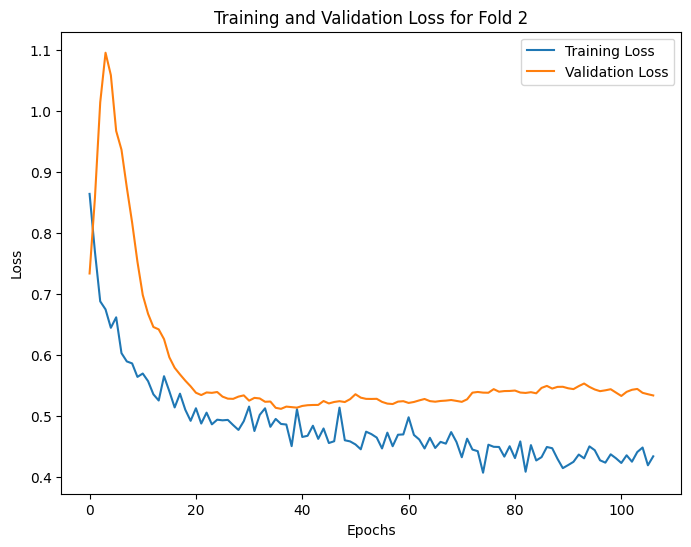


Training fold 3...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 3 ROC AUC Score: 0.8055


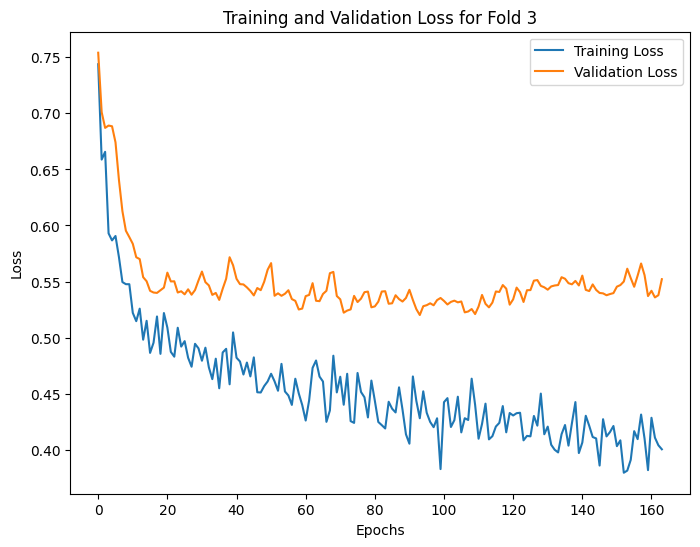


Training fold 4...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 4 ROC AUC Score: 0.8395


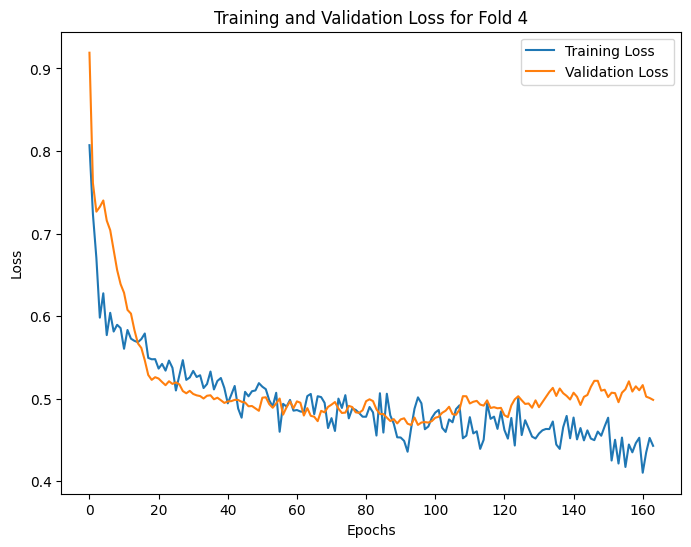


Training fold 5...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 5 ROC AUC Score: 0.8305


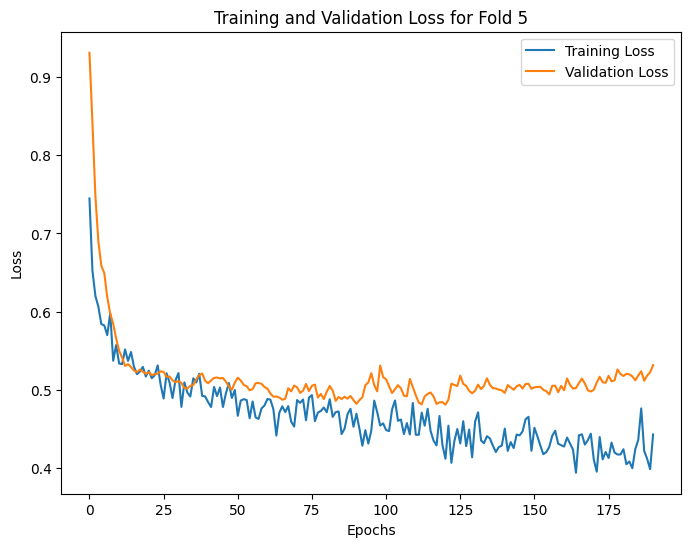


Training fold 6...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 6 ROC AUC Score: 0.8019


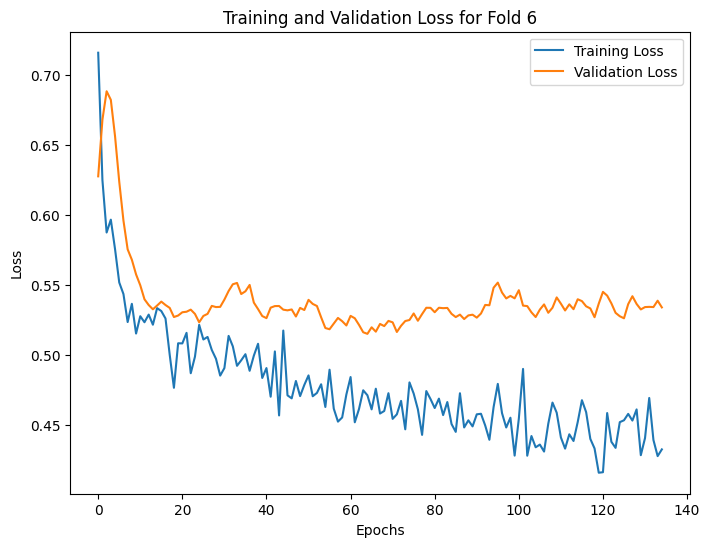


Training fold 7...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 7 ROC AUC Score: 0.8264


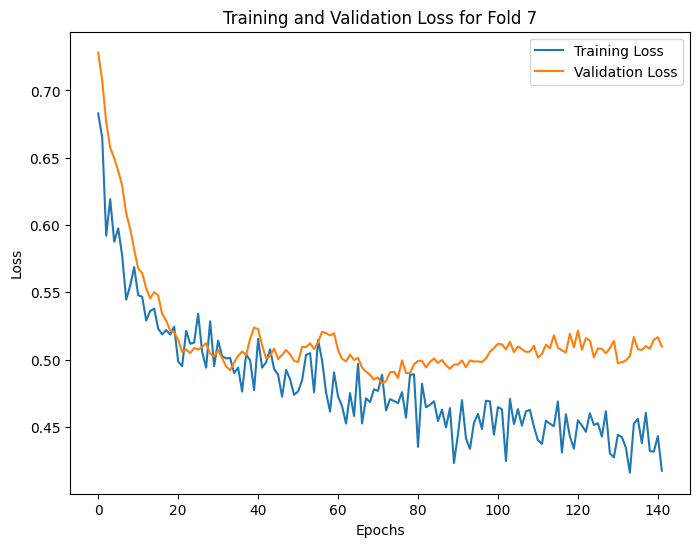


Training fold 8...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Fold 8 ROC AUC Score: 0.8114


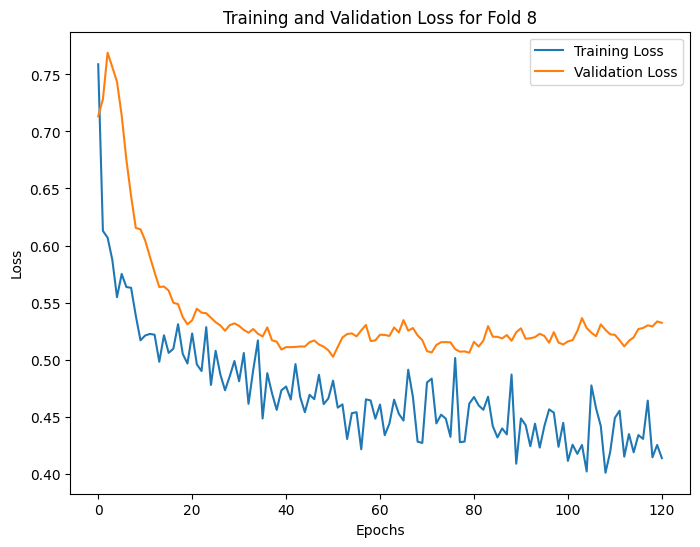


Average ROC AUC Score across all folds: 0.8185


In [ ]:

#data
X = df.drop('Outcome', axis=1)
#labels
y = df['Outcome']

# Define model architecture with specific layer settings
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))       # Input layer
    x = Dense(128, use_bias=False)(inputs)      # First dense layer without bias
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    x = Dropout(0.2)(x)                        # Dropout layer to prevent overfitting

    x = Dense(64, use_bias=False)(x)           # Second dense layer without bias
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    x = Dropout(0.1)(x)                        # Dropout layer

    x = Dense(32, use_bias=False)(x)            # Third dense layer without bias (New layer)
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    #x = Dropout(0.1)(x)                        # Dropout layer

    x = Dense(16, use_bias=False)(x)            # Third dense layer without bias (New layer)
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    #x = Dropout(0.1)(x)                        # Dropout layer

    x = Dense(8, use_bias=False)(x)            # Third dense layer without bias (New layer)
    x = BatchNormalization()(x)                # Batch normalization before activation
    x = Activation('relu')(x)                  # ReLU activation function
    #x = Dropout(0.1)(x)                        # Dropout layer

    outputs = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid for binary classification
    model = Model(inputs=inputs, outputs=outputs)  # Define the model
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])           # Compile with Adam optimizer and binary cross-entropy loss
    return model

# Define iterated k-fold cross-validation with shuffling
k_folds = 2                # Number of folds
n_repeats = 4              # Number of repetitions
rkf = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=42)
fold_no = 1

# Store AUC scores for all folds
auc_scores = []

for train_index, val_index in rkf.split(X, y):
    print(f"\nTraining fold {fold_no}...\n")

    # Split data for current fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create model
    model = create_model(X_train.shape[1])

    # EarlyStopping callback to avoid overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=70,                   # Stop after 10 epochs with no improvement
        restore_best_weights=True      # Restore best weights after stopping
    )

    # Train model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,                    # Maximum number of epochs
        batch_size=16,                 # Smaller batch size for better generalization
        verbose=0,
        callbacks=[early_stopping]     # Add early stopping callback
    )

    # Compute and store ROC AUC Score for the holdout set
    y_val_pred = model.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(roc_auc)
    print(f"Fold {fold_no} ROC AUC Score: {roc_auc:.4f}")

    # Plot training and validation loss for each fold
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    fold_no += 1

# Print overall average AUC score across all folds
average_auc = np.mean(auc_scores)
print(f"\nAverage ROC AUC Score across all folds: {average_auc:.4f}")

# Automating HP Tuning

Now we know we are capable of overfitting, **let's now try automatically  select these hyperparameters**: the number of layers (between 2 and 4), the number of neurons per layer (starting at 128 and decreasing by a factor of 2 between each layer),  whether or not bias is used, the activation function (just try 3 of the most common functions, reLU, sigmoid and another). The amount of dropout per layer, whether or not Early Stopping is used, the patience of the early stopping, the batch size, the learning rate.

From now on, we want to actually see how well our model is performing so we will use a holdout test set to evaluate our HPs.

If we don't do this we are essentially training on our test set (training hyperparameters, not parameters)

In [ ]:
#data
X = df.drop('Outcome', axis=1)
#labels
y = df['Outcome']

# Define model architecture with specific layer settings
def create_model(hp):
    inputs = Input(shape=(X.shape[1],))       # Input layer

    x = inputs

    #tune number of layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)

    for i in range(num_layers):
        # Tune the number of neurons
        units = hp.Int(f'units_{i}', min_value=8, max_value=128, step=32)

        # Tune whether to use bias
        use_bias = hp.Boolean(f'use_bias_{i}')

        x = Dense(units, use_bias=use_bias)(x)

        # Tune the activation function
        activation = hp.Choice(f'activation_{i}', values=['relu', 'sigmoid', 'tanh'])
        x = Activation(activation)(x)

        # Tune the dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        x = Dropout(dropout_rate)(x)

        # Add Batch Normalization (optional, you can tune this too)
        x = BatchNormalization()(x)


    outputs = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid for binary classification
    model = Model(inputs=inputs, outputs=outputs)  # Define the model

    #tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')

    # Tune batch size
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])  # Add batch_size to hyperparameters

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])           # Compile with Adam optimizer and binary cross-entropy loss
    return model

# Define the tuner
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice/Hyperparam_tuning',
                     project_name='nn_feedforward_pimas_HPs_newrun')
# ... (previous imports and data loading) ...

# Split data into training/validation and holdout test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define k-fold cross-validation for hyperparameter tuning
k_folds = 5  # Adjust as needed
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store AUC scores for all folds
auc_scores = []

# Loop through folds for hyperparameter tuning
for fold_no, (train_index, val_index) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\nTraining fold {fold_no + 1}...\n")

    # Split data for current fold
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # --- Hyperparameter search using Keras Tuner within the fold ---
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    # --- End Hyperparameter Search ---

    batch_size = best_hps.get('batch_size')

    if batch_size is None:
        batch_size = 16

    # Train the best model for this fold on the full training/validation data
    history = model.fit(X_train_val, y_train_val,
                        epochs=100,
                        batch_size=batch_size,
                        verbose=0,
                        validation_data=(X_val, y_val))

    # Evaluate on the holdout test set
    y_test_pred = model.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    auc_scores.append(roc_auc_test)
    print(f"Fold {fold_no + 1} Test ROC AUC Score: {roc_auc_test:.4f}")

# Print overall average AUC score on the holdout test set
average_auc_test = np.mean(auc_scores)
print(f"\nTest ROC AUC Score (after k-fold HP tuning): {average_auc_test:.4f}")


Automate pushing to github:

In [8]:
import datetime

now = datetime.datetime.now()
current_datetime = now.strftime("%Y-%m-%d %H:%M")

!git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

# Replace with your desired commit message
COMMIT_MESSAGE= str(current_datetime) + " - added better formatting"

# Replace with your actual username and email (or configure globally)
USERNAME="archiegoodman2"
EMAIL="archiegoodman2011@gmail.com"

# Navigate to the repository directory (if not already there)
%cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

# Set global username and email configuration
!git config --global user.name "$USERNAME"
!git config --global user.email "$EMAIL"

# Stage all changes
!git add .

# Commit the changes
!git commit -m "$COMMIT_MESSAGE"


/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice
[master cea3757] 2024-12-02 21:13 - added better formatting
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')